In [1]:
import matplotlib.pyplot as plt  # For creating visualizations and plots
import numpy as np  # For numerical operations, especially on arrays and matrices
from collections import Counter  # For counting hashable objects like words in a list
from itertools import chain  # For flattening lists of lists into a single list
import pandas as pd  # For data manipulation and analysis, especially with DataFrames
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, Trainer, TrainingArguments, get_scheduler  # For working with transformer models
import re  # For regular expression operations, useful in text processing

2024-08-18 09:04:56.424397: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-18 09:04:56.494745: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-18 09:04:56.494782: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-18 09:04:56.494821: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-18 09:04:56.512679: I tensorflow/core/platform/cpu_feature_g

In [2]:
# Path to the output CSV file
output_file = './coreference_batches.csv'

# Load the first 3000 rows of the CSV file into a DataFrame
cleaned_df = pd.read_csv(output_file)

# Rename 'processed_description' to 'cleaned_description'
cleaned_df.rename(columns={'processed_description': 'cleaned_description'}, inplace=True)

# Rename 'processed_abstract' to 'cleaned_abstract'
cleaned_df.rename(columns={'processed_abstract': 'cleaned_abstract'}, inplace=True)

# Rename 'processed_processed_description' to 'coreference_description'
cleaned_df.rename(columns={'processed_processed_description': 'coreference_description'}, inplace=True)

# Rename 'processed_processed_abstract' to 'coreference_abstract'
cleaned_df.rename(columns={'processed_processed_abstract': 'coreference_abstract'}, inplace=True)

In [3]:
class PostProcessing:
    def __init__(self, model, tokenizer, dataset, description_column, abstract_column, max_input_length=2048, max_target_length=256):
        """
        Initialize the PostProcessing class with model, tokenizer, dataset, and column names.

        Args:
            model (AutoModelForSeq2SeqLM): The trained model.
            tokenizer (AutoTokenizer): The tokenizer associated with the model.
            dataset (Dataset): The dataset used for further analysis or testing.
            description_column (str): The column name for the source text (abstractive description).
            abstract_column (str): The column name for the reference summary (abstractive abstract).
            max_input_length (int): Maximum length of input sequences.
            max_target_length (int): Maximum length of output sequences.
        """
        self.model = model
        self.tokenizer = tokenizer
        self.dataset = dataset
        self.description_column = description_column
        self.abstract_column = abstract_column
        self.max_input_length = max_input_length
        self.max_target_length = max_target_length

    def manual_inspection(self, passage, num_beams=5, length_penalty=1.0, temperature=1.0, top_k=50, top_p=0.95):
        """
        Manually inspect the model's output for a given passage.

        Args:
            passage (str): The passage to generate a summary for.
            num_beams (int): Number of beams for beam search.
            length_penalty (float): Length penalty for beam search.
            temperature (float): Temperature for sampling.
            top_k (int): Top-k sampling parameter.
            top_p (float): Top-p (nucleus) sampling parameter.
        """
        input_ids = self.tokenizer.encode(passage, return_tensors='pt', truncation=True, max_length=self.max_input_length)

        # Generate summary with adjusted parameters
        generated_ids = self.model.generate(
            input_ids,
            max_length=self.max_target_length,
            num_beams=num_beams,
            length_penalty=length_penalty,
            temperature=temperature,
            top_k=top_k,
            top_p=top_p,
            early_stopping=True
        )
        generated_summary = self.tokenizer.decode(generated_ids[0], skip_special_tokens=True)

        print(f"Input Passage:\n{passage}\n")
        print(f"Generated Summary:\n{generated_summary}\n")
        print("="*50)
        
    def generate_summary(self, passage):
        """
        Generate a summary for a given passage.

        Args:
            passage (str): The passage to generate a summary for.
        
        Returns:
            str: The generated summary.
        """
        input_ids = self.tokenizer.encode(passage, return_tensors='pt', truncation=True, max_length=self.max_input_length)
        generated_ids = self.model.generate(input_ids, max_length=self.max_target_length, num_beams=2, length_penalty=1.0, early_stopping=True)
        generated_summary = self.tokenizer.decode(generated_ids[0], skip_special_tokens=True)
        return generated_summary


    def plot_summary_length_distribution(self, num_samples=None):
        """
        Plot the distribution of generated summary lengths.

        Args:
            num_samples (int, optional): Number of samples to include in the plot. If None, use all samples.
        """
        summary_lengths = []
        num_samples = num_samples or len(self.dataset)

        for i in range(min(num_samples, len(self.dataset))):
            source_text = self.dataset.iloc[i][self.description_column]
            input_ids = self.tokenizer.encode(source_text, return_tensors='pt', truncation=True, max_length=self.max_input_length)
            generated_ids = self.model.generate(input_ids, max_length=self.max_target_length, num_beams=2, length_penalty=1.0, early_stopping=True)
            generated_summary = self.tokenizer.decode(generated_ids[0], skip_special_tokens=True)
            summary_lengths.append(len(generated_summary.split()))

        plt.hist(summary_lengths, bins=20, alpha=0.7, color='blue', edgecolor='black')
        plt.title('Distribution of Generated Summary Lengths')
        plt.xlabel('Number of Tokens')
        plt.ylabel('Frequency')
        plt.grid(axis='y', alpha=0.75)
        plt.show()


    @classmethod
    def load_model(cls, load_directory, dataset, description_column, abstract_column, max_input_length=2048, max_target_length=256, model_name=None):
        """
        Load the model and tokenizer for post-processing.

        Args:
            load_directory (str): Directory from where to load the model and tokenizer.
            dataset (Dataset): The dataset used for further analysis or testing.
            description_column (str): The column name for the source text (abstractive description).
            abstract_column (str): The column name for the reference summary (abstractive abstract).
            max_input_length (int): Maximum length of input sequences.
            max_target_length (int): Maximum length of output sequences.
            model_name (str, optional): The model identifier, if known. Can be omitted if loading from a saved model.

        Returns:
            PostProcessing: An instance of PostProcessing with the loaded model and tokenizer.
        """
        # Load the model and tokenizer
        model = AutoModelForSeq2SeqLM.from_pretrained(load_directory)
        tokenizer = AutoTokenizer.from_pretrained(load_directory)

        # If model_name is not provided, try to infer it from the loaded tokenizer or model
        if model_name is None:
            try:
                model_name = tokenizer.name_or_path
            except AttributeError:
                raise ValueError("The model name could not be inferred and must be provided explicitly.")

        # Create and return a PostProcessing instance with the loaded components
        return cls(model, tokenizer, dataset, description_column, abstract_column, max_input_length, max_target_length)


def clean_text(text):
    """
    Clean the input text by removing special characters, extra whitespace, and correcting spelling and grammar.

    Args:
        text (str): The input text to clean.

    Returns:
        str: The cleaned text.
    """
    # Remove special characters (except periods and commas)
    text = re.sub(r'[^a-zA-Z0-9.,\s]', '', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    # Optionally: convert to lowercase (depends on the use case)
    text = text.lower()
    

    return text


In [4]:
description_column = 'coreference_description'
abstract_column = 'coreference_abstract'

In [5]:
input_story = """
Once upon a time in a small village nestled between rolling hills and dense forests, there lived a young girl named Elara. Elara was known throughout the village for her kindness and adventurous spirit. She lived with her grandmother in a quaint cottage on the edge of the forest.
One sunny morning, while Elara was exploring the woods, she stumbled upon a hidden path she had never seen before. Curious and excited, she decided to follow it. The path led her deeper into the forest, where the trees grew taller and the air felt cooler.
As she walked, Elara noticed strange, glowing flowers lining the path. She picked one and placed it in her hair. Suddenly, she heard a soft whispering sound. "Who are you?" a gentle voice asked. Elara looked around but saw no one.
"Who are you?" the voice repeated, a bit louder this time. Elara realized the voice was coming from the flower in her hair. "I am Elara," she replied. "And who are you?"
"I am Lumina, the guardian of the forest," the flower said. "You have entered a magical realm. Few humans can find this path, but those who do are destined for a great adventure."
Elara's eyes sparkled with excitement. "What kind of adventure?" she asked.
"The kind that will test your bravery and kindness," Lumina replied. "Follow the path to the ancient oak tree. There, you will find a portal to another world."
Elara's heart raced as she continued down the path. Soon, she arrived at a massive oak tree with a shimmering portal at its base. She took a deep breath and stepped through the portal.
On the other side, Elara found herself in a land unlike any she had ever seen. The sky was filled with vibrant colors, and mythical creatures roamed freely. She met a unicorn named Starfire, who became her guide and companion.
Together, they embarked on a quest to find the lost gems of harmony, which had the power to bring peace to the land. Along the way, they faced various challenges: they outsmarted a cunning dragon, solved ancient riddles, and helped a village of talking animals rebuild their homes after a storm.
Through each trial, Elara's bravery and kindness shone brightly. With Starfire's help, she found all the gems and placed them in a sacred altar. A brilliant light erupted from the altar, and a sense of calm and joy spread across the land.
As a reward for her courage and compassion, Lumina granted Elara a wish. Elara wished to return home but asked to keep a piece of the magical realm with her. Lumina gave her a small, enchanted locket that would always remind her of her adventure and the friends she had made.
Elara returned to her village, where she shared her incredible journey with her grandmother and friends. Though her life seemed normal again, she knew that she carried a spark of magic within her heart, and she continued to explore and spread kindness wherever she went.
And so, Elara's legend grew, inspiring generations of villagers to believe in the power of bravery, kindness, and the magic of the unknown.
"""


In [6]:
input_story ="""
The tower is 324 metres (1,063 ft) tall, about the same height as an 81-storey building, and the tallest structure in Paris. Its base is square, measuring 125 metres (410 ft) on each side. During its construction, the Eiffel Tower surpassed the Washington Monument to become the tallest man-made structure in the world, a title it held for 41 years until the Chrysler Building in New York City was finished in 1930. It was the first structure to reach a height of 300 metres. Due to the addition of a broadcasting aerial at the top of the tower in 1957, it is now taller than the Chrysler Building by 5.2 metres (17 ft). Excluding transmitters, the Eiffel Tower is the second tallest free-standing structure in France after the Millau Viaduct."""

In [7]:
# Clean the input story
cleaned_story = clean_text(input_story)

<h3>LED MODEL</h3>

In [8]:
# Load the pretrained model from Hugging Face
pretrained_post_processor = PostProcessing(
    model=AutoModelForSeq2SeqLM.from_pretrained("allenai/led-base-16384"), 
    tokenizer=AutoTokenizer.from_pretrained("allenai/led-base-16384"),  # Use the corresponding tokenizer
    dataset=cleaned_df,
    description_column=description_column,
    abstract_column=abstract_column,
    max_input_length=1024,
    max_target_length=256
)

In [9]:
# Generate summary using the pretrained model from Hugging Face
pretrained_summary = pretrained_post_processor.generate_summary(input_story)
print(f"Pretrained Model Summary:\n{pretrained_summary}\n")

Input ids are automatically padded from 172 to 1024 to be a multiple of `config.attention_window`: 1024


Pretrained Model Summary:
The tower is 324 metres (1,063 ft) tall, about the same height as an 81-storey building, and the tallest structure in Paris. Its base is square, measuring 125 metres (410 ft) on each side. During its construction, the Eiffel Tower surpassed the Washington Monument to become the tallest man-made structure in the world, a title it held for 41 years until the Chrysler Building in New York City was finished in 1930. It was the first structure to reach a height of 300 metres. Due to the addition of a broadcasting aerial at the top of the tower in 1957, it is now taller than the Chrysler Building by 5.2 metres (17 ft). Excluding transmitters, the Eiffel Tower is the second tallest free-standing structure in France after the Millau Viaduct.



In [10]:
# Load a previously saved model and tokenizer for post-processing
loaded_post_processor = PostProcessing.load_model(
    load_directory="./led-model",  # Directory where the saved model and tokenizer are stored
    dataset=cleaned_df,  # The dataset to be used for further processing, assumed to be pre-cleaned
    description_column=description_column,  # The column in the dataset containing input descriptions
    abstract_column=abstract_column,  # The column in the dataset containing target summaries (abstracts)
    max_input_length=1024,  # Maximum length for input sequences (in tokens)
    max_target_length=256  # Maximum length for output sequences (in tokens)
)

In [11]:
# Manually inspect the summary generated for the input passage
loaded_post_processor.manual_inspection(input_story)

/home/792759/.local/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:545: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Input Passage:

The tower is 324 metres (1,063 ft) tall, about the same height as an 81-storey building, and the tallest structure in Paris. Its base is square, measuring 125 metres (410 ft) on each side. During its construction, the Eiffel Tower surpassed the Washington Monument to become the tallest man-made structure in the world, a title it held for 41 years until the Chrysler Building in New York City was finished in 1930. It was the first structure to reach a height of 300 metres. Due to the addition of a broadcasting aerial at the top of the tower in 1957, it is now taller than the Chrysler Building by 5.2 metres (17 ft). Excluding transmitters, the Eiffel Tower is the second tallest free-standing structure in France after the Millau Viaduct.

Generated Summary:
The tower is 324 metres (1,063 ft) tall, about the same height as an 81-storey building, and the tallest structure in Paris. Its base is square, measuring 125 metres (410 ft) on each side



In [12]:
#  summary generated for the cleaned input passage
loaded_post_processor.generate_summary(cleaned_story)

Input ids are automatically padded from 171 to 1024 to be a multiple of `config.attention_window`: 1024


'the tower is 324 metres 1,063 ft tall, about the same height as an 81storey building, and the tallest structure in paris. its base is square, measuring 125 metres 410 ft on each side.During its construction, the eiffel tower surpassed the washington monument to become the tallest manmade structure in the world, a title it held for 41 years until the chrysler building in new york city was finished in 1930. it was the first structure to reach a height of 300 metres. due to the addition of a broadcasting aerial at the top of the tower in 1957, it is now taller than the chrysler building by 5.2 metres 17 ft. excluding transmitters, the eiffel tower is the second tallest freestanding structure in france after the millau viaduct'

Input ids are automatically padded from 930 to 1024 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 969 to 1024 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 797 to 1024 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 438 to 1024 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1017 to 1024 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 726 to 1024 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 591 to 1024 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 859 to 1024 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 928 to 1024 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 967 to 1024 to be a mul

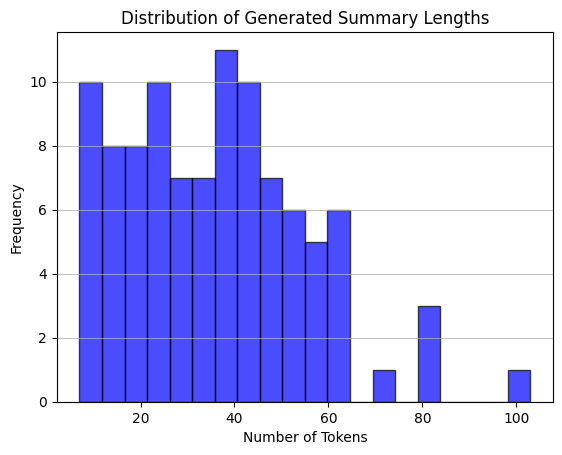

In [13]:
loaded_post_processor.plot_summary_length_distribution(num_samples=100)

<h3>T5 Long</h3>

In [14]:
# Load the pretrained model from Hugging Face
pretrained_post_processor = PostProcessing(
    model=AutoModelForSeq2SeqLM.from_pretrained("google/long-t5-tglobal-base"), 
    tokenizer=AutoTokenizer.from_pretrained("google/long-t5-tglobal-base"),  # Use the corresponding tokenizer
    dataset=cleaned_df,
    description_column=description_column,
    abstract_column=abstract_column,
    max_input_length=2048,
    max_target_length=256
)

In [15]:
# Generate summary using the pretrained model from Hugging Face
pretrained_summary = pretrained_post_processor.generate_summary(input_story)
print(f"Pretrained Model Summary:\n{pretrained_summary}\n")

/home/792759/.local/lib/python3.11/site-packages/transformers/modeling_utils.py:1014: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Pretrained Model Summary:
The tower is 324 metres (1,063 ft) tall, about the same height as an 81-storey building, and the tallest structure in Paris.



In [16]:
# Load a previously saved model and tokenizer for post-processing
loaded_trainer_t5_long = PostProcessing.load_model(
    load_directory="./t5_long-model",  # Directory where the saved model and tokenizer are stored
    dataset=cleaned_df,  # The dataset to be used for further processing, assumed to be pre-cleaned
    description_column=description_column,  # The column in the dataset containing input descriptions
    abstract_column=abstract_column,  # The column in the dataset containing target summaries (abstracts)
    max_input_length=1024,  # Maximum length for input sequences (in tokens)
    max_target_length=256  # Maximum length for output sequences (in tokens)
)

In [17]:
# Manually inspect the summary generated for the input passage
loaded_trainer_t5_long.manual_inspection(input_story)

Input Passage:

The tower is 324 metres (1,063 ft) tall, about the same height as an 81-storey building, and the tallest structure in Paris. Its base is square, measuring 125 metres (410 ft) on each side. During its construction, the Eiffel Tower surpassed the Washington Monument to become the tallest man-made structure in the world, a title it held for 41 years until the Chrysler Building in New York City was finished in 1930. It was the first structure to reach a height of 300 metres. Due to the addition of a broadcasting aerial at the top of the tower in 1957, it is now taller than the Chrysler Building by 5.2 metres (17 ft). Excluding transmitters, the Eiffel Tower is the second tallest free-standing structure in France after the Millau Viaduct.

Generated Summary:
During it construction a Eiffel Tower surpassed a Washington Monument to become tallest man made structure in a world a title it holding for 41 years a Chrysler Building in New York City was finished in 1930



In [18]:
#  summary generated for the cleaned input passage
loaded_trainer_t5_long.generate_summary(cleaned_story)

'due to a broadcasting aerial at top height in 1957 it is still taller than chrysler buildingby 5.2 metres 17 ft'

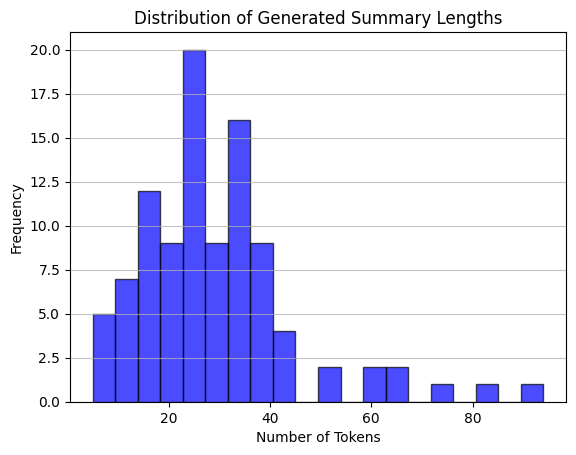

In [19]:
loaded_trainer_t5_long.plot_summary_length_distribution(num_samples=100)

<h3>Distil Bart</h3>

In [20]:
# Load the pretrained model from Hugging Face
pretrained_post_processor_bart = PostProcessing(
    model=AutoModelForSeq2SeqLM.from_pretrained("sshleifer/distilbart-cnn-12-6"), 
    tokenizer=AutoTokenizer.from_pretrained("sshleifer/distilbart-cnn-12-6"),  # Use the corresponding tokenizer
    dataset=cleaned_df,
    description_column=description_column,
    abstract_column=abstract_column,
    max_input_length=2048,
    max_target_length=256
)

In [21]:
# Generate summary using the pretrained model from Hugging Face
pretrained_summary = pretrained_post_processor_bart.generate_summary(input_story)
print(f"Pretrained Model Summary:\n{pretrained_summary}\n")

Pretrained Model Summary:
 The Eiffel Tower is 324 metres (1,063 ft) tall, about the same height as an 81-storey building. It was the first structure to reach a height of 300 metres. It is now taller than the Chrysler Building in New York City by 5.2 metres (17 ft) Excluding transmitters, it is the second tallest free-standing structure in France after the Millau Viaduct.



In [22]:
# Load a previously saved model and tokenizer for post-processing
loaded_trainer_distil_bart = PostProcessing.load_model(
    load_directory="./bart-model",  # Directory where the saved model and tokenizer are stored
    dataset=cleaned_df,  # The dataset to be used for further processing, assumed to be pre-cleaned
    description_column=description_column,  # The column in the dataset containing input descriptions
    abstract_column=abstract_column,  # The column in the dataset containing target summaries (abstracts)
    max_input_length=1024,  # Maximum length for input sequences (in tokens)
    max_target_length=256  # Maximum length for output sequences (in tokens)
)

In [23]:
# Manually inspect the summary generated for the input passage
loaded_trainer_distil_bart.manual_inspection(input_story)

Input Passage:

The tower is 324 metres (1,063 ft) tall, about the same height as an 81-storey building, and the tallest structure in Paris. Its base is square, measuring 125 metres (410 ft) on each side. During its construction, the Eiffel Tower surpassed the Washington Monument to become the tallest man-made structure in the world, a title it held for 41 years until the Chrysler Building in New York City was finished in 1930. It was the first structure to reach a height of 300 metres. Due to the addition of a broadcasting aerial at the top of the tower in 1957, it is now taller than the Chrysler Building by 5.2 metres (17 ft). Excluding transmitters, the Eiffel Tower is the second tallest free-standing structure in France after the Millau Viaduct.

Generated Summary:
tall man made Eiffel Tower Tower 324 metres (1,063 ft) tall tower base is square measuring 125 metres (410 ft) on each side tower is second tallest free standing structure in France after Millau Viaduct tower inlet is cu

In [24]:
#  summary generated for the cleaned input passage
loaded_trainer_distil_bart.generate_summary(cleaned_story)

'tall manmade structure first tower tower in France since 1931 when it was first structure to reach height of 300 metres due addition a radioactivity repeller at top tower tower is now taller than one nearby antennae structure 5.2 metres 17 ft excluding transmitters antennae transmitters'

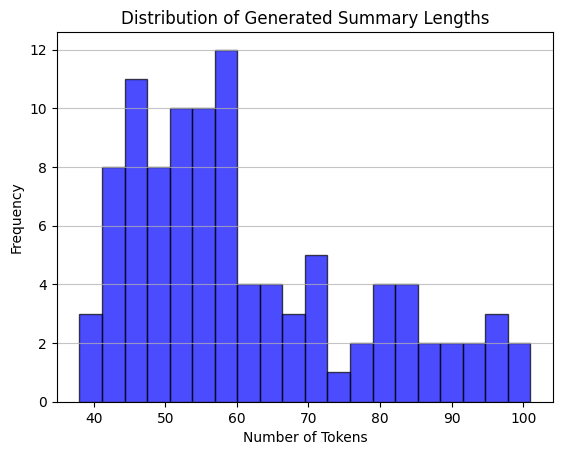

In [25]:
loaded_trainer_distil_bart.plot_summary_length_distribution(num_samples=100)

<h3>BigBird Pegasus</h3>

In [26]:
# Load the pretrained model from Hugging Face
pretrained_post_processor_bigbird_pegasus = PostProcessing(
    model=AutoModelForSeq2SeqLM.from_pretrained("google/bigbird-pegasus-large-arxiv"), 
    tokenizer=AutoTokenizer.from_pretrained("google/bigbird-pegasus-large-arxiv"),  # Use the corresponding tokenizer
    dataset=cleaned_df,
    description_column=description_column,
    abstract_column=abstract_column,
    max_input_length=2048,
    max_target_length=256
)

In [27]:
# Generate summary using the pretrained model from Hugging Face
pretrained_summary = pretrained_post_processor_bigbird_pegasus.generate_summary(input_story)
print(f"Pretrained Model Summary:\n{pretrained_summary}\n")

Attention type 'block_sparse' is not possible if sequence_length: 158 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


Pretrained Model Summary:
the top of the tower is 324063 metres ( ft ).<n> the base of the tower is 81063 metres ( ft ).<n> the tower is 324063 metres ( ft ). <n> the top of the tower is 324063 metres ( ft ). <n> the base of the tower is 81063 metres ( ft ). <n> the tower is 324063 metres ( ft ). <n> the base of the tower is 81063 metres ( ft ). <n> the top of the tower is 324063 metres ( ft ). <n> the base of the tower is 81063 metres ( ft ). <n> the tower is 324063 metres ( ft ). <n> the base of the tower is 81063 metres ( ft ). <n> the tower is 324063 metres ( ft ). <n> the tower is 324063 metres ( ft ). <n> the base of the tower is 81063 metres ( ft ). <n> the tower is 324063 metres ( ft ). <n> the base of the tower is 81063 metres ( ft ). <n> the tower is



In [28]:
# Load a previously saved model and tokenizer for post-processing
loaded_trainer_bigbird_pegasus = PostProcessing.load_model(
    load_directory="./bigbrid_pegasus-model",  # Directory where the saved model and tokenizer are stored
    dataset=cleaned_df,  # The dataset to be used for further processing, assumed to be pre-cleaned
    description_column=description_column,  # The column in the dataset containing input descriptions
    abstract_column=abstract_column,  # The column in the dataset containing target summaries (abstracts)
    max_input_length=1024,  # Maximum length for input sequences (in tokens)
    max_target_length=256  # Maximum length for output sequences (in tokens)
)

In [29]:
# Manually inspect the summary generated for the input passage
loaded_trainer_bigbird_pegasus.manual_inspection(input_story)

Attention type 'block_sparse' is not possible if sequence_length: 158 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


Input Passage:

The tower is 324 metres (1,063 ft) tall, about the same height as an 81-storey building, and the tallest structure in Paris. Its base is square, measuring 125 metres (410 ft) on each side. During its construction, the Eiffel Tower surpassed the Washington Monument to become the tallest man-made structure in the world, a title it held for 41 years until the Chrysler Building in New York City was finished in 1930. It was the first structure to reach a height of 300 metres. Due to the addition of a broadcasting aerial at the top of the tower in 1957, it is now taller than the Chrysler Building by 5.2 metres (17 ft). Excluding transmitters, the Eiffel Tower is the second tallest free-standing structure in France after the Millau Viaduct.

Generated Summary:
the commensurability commensurability is defined commensurability tower commensurability tower commensurability tower



In [30]:
loaded_trainer_bigbird_pegasus.generate_summary(cleaned_story)

'the eiffel tower is a freestanding structure measuring 5.2 metres tall at base.'

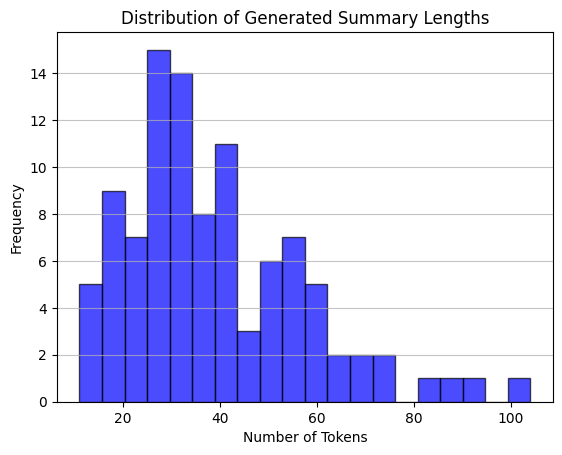

In [31]:
loaded_trainer_bigbird_pegasus.plot_summary_length_distribution(num_samples=100)